In [1]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import numpy as np

import src.models
import orbax.checkpoint
from src.training import train_utils
from src.data_generate_sde import sde_utils, time

from src.data_generate_sde import sde_kunita

Setup to load in checkpoint

In [2]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()

T = 1.0
N = 100

def get_score(checkpoint_path):
    restored = orbax_checkpointer.restore(checkpoint_path)
    model = src.models.score_mlp.ScoreMLP(**restored["network"])
    params = restored["params"]
    trained_score = train_utils.trained_score(model, params)
    sde = restored["sde"]
    return trained_score, sde


In [3]:
checkpoint_path = f"/Users/libbybaker/Documents/Python/doobs-score-project/doobs_score_matching/checkpoints/kunita/fixed_y_lms_5_forward"

trained_score, sde = get_score(checkpoint_path)

In [4]:
ts_cond = time.grid(0, T, N)
num_landmarks = 5


def sample_circle(num_landmarks: int, radius: float, centre=jnp.asarray([0, 0])) -> jnp.ndarray:
    theta = jnp.linspace(0, 2 * jnp.pi, num_landmarks, endpoint=False)
    x = jnp.cos(theta)
    y = jnp.sin(theta)
    return (radius * jnp.stack([x, y], axis=1) + centre)

def conditioned_fn(key):
    drift, diffusion = sde_kunita.vector_fields()
    traj = sde_utils.conditioned(key, ts_cond, x0, trained_score, drift, diffusion)
    return traj

x0 = sample_circle(num_landmarks, 1.2).flatten()

target = sample_circle(num_landmarks, 1.)
keys = jax.random.split(jax.random.PRNGKey(20), 2)
conditioned_trajs = jax.vmap(conditioned_fn)(keys)

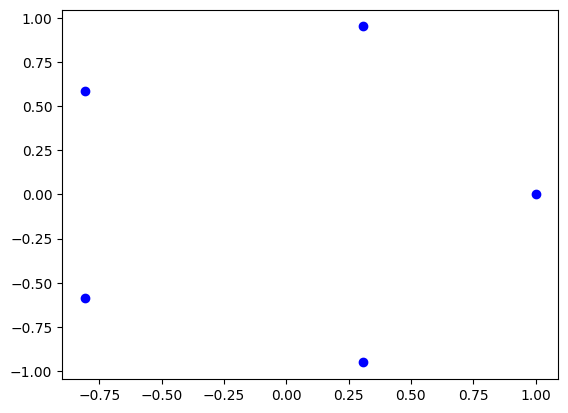

In [9]:
plt.scatter(target[:, 0], target[:, 1], color='blue')

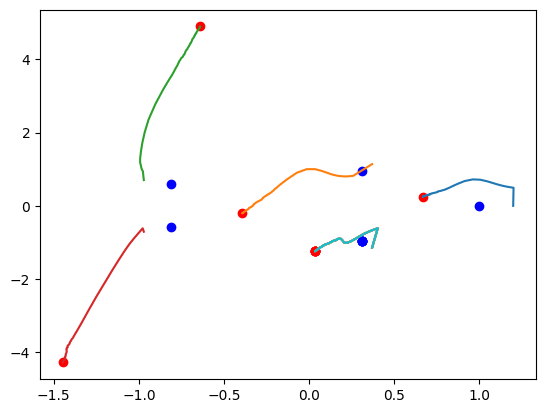

In [5]:
import matplotlib.pyplot as plt

conditioned_trajs = conditioned_trajs.reshape(2, N, num_landmarks, 2)

for landmark in jnp.arange(0, 10, 1):
    plt.plot(conditioned_trajs[0, :, landmark, 0], conditioned_trajs[0, :, landmark, 1])
    plt.scatter(conditioned_trajs[0, -1, landmark, 0], conditioned_trajs[0, -1, landmark, 1], color='red')
    plt.scatter(target[landmark, 0], target[landmark, 1], color='blue')
plt.show()


In [6]:
checkpoint_path_f = f"/Users/libbybaker/Documents/Python/doobs-score-project/doobs_score_matching/checkpoints/kunita/fixed_x0_lms_5"

trained_score_fw, sde = get_score(checkpoint_path)

In [7]:
drift, diffusion = sde_kunita.vector_fields()
key = jax.random.PRNGKey(5)
backward_trajs = sde_utils.backward(key, ts_cond, x0, trained_score_fw, drift, diffusion)

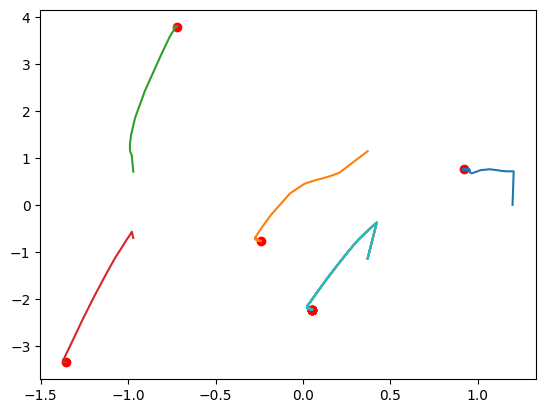

In [8]:
backward_trajs = backward_trajs.reshape(1, N, num_landmarks, 2)

for landmark in jnp.arange(0, 10, 1):
    plt.plot(backward_trajs[0, :, landmark, 0], backward_trajs[0, :, landmark, 1])
    plt.scatter(backward_trajs[0, -1, landmark, 0], backward_trajs[0, -1, landmark, 1], color='red')
plt.show()